Loading essencial libraries

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import random
from matplotlib.path import Path
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from tqdm import tqdm

Room shape and properties

In [136]:
wallVerticesX = np.array([0,0,10,10])
wallVerticesY = np.array([0,8,8,0])
wall_absorption = np.array([0,0,0,0])
wall_diffraction = np.array([0,0,0,0])

Starting values:

In [165]:
roomEdges = 4
rayCount = 500
maxCollisions = 10000
startEnergy = 5
frequency = 125
frequencies = [125, 250, 500, 1000, 2000, 4000]
energyLoss = [0.5, 0, 0.0, 0.0, 0.0, 0.0]
speed_of_sound = 343

distance_attenuation = False
distance_loss_factor = 0 # dB/m
distance_loss_linear = 0

sourceX = 2
sourceY = 3

minAngle = 0.0
maxAngle = 2 * np.pi

micCount = 1
microphones = []

micX = [5]
micY = [5]
micRadius = [0.4]
microphones = [{
    'position': (micX[i], micY[i]),
    'radius': micRadius[i],
    'absorbed_energy': 0.0,
    'ray_count': 0,
    'energy_history': [],
    'time_history': [],
    'distance_history': [],
    'bounce_history': [],
    'initial_angles': []
} for i in range(micCount)]

wallVertices = np.array([wallVerticesX, wallVerticesY])

create_ray_render = False
create_energy_map = True
create_energy_curves = True

grid_size = 0.1

show_energy_color = False
show_bounce_points = False
show_energy_text = False
show_ray_paths = False
show_energy_time_graph = False


Functions:

In [147]:
# Функции для расчёта энергии с учётом расстояния
def calculate_distance_energy(initial_energy, distance, distance_loss_linear):
    """Расчёт энергии с учётом затухания на расстоянии"""
    if distance_attenuation:
        distance_effect = 1.0 / (1.0 + distance)
        attenuation = distance_loss_linear ** distance
        return initial_energy * distance_effect * attenuation
    else:
        return initial_energy / (1.0 + distance ** 2)


def calculate_total_distance(path_x, path_y):
    """Расчёт общего расстояния, пройденного лучом"""
    total_dist = 0.0
    for i in range(len(path_x) - 1):
        dx = path_x[i + 1] - path_x[i]
        dy = path_y[i + 1] - path_y[i]
        total_dist += np.sqrt(dx ** 2 + dy ** 2)
    return total_dist


# Функции геометрии
def to_angle(sin_a, cos_a):
    angle = np.atan2(sin_a, cos_a)
    if angle < 0:
        angle += 2 * np.pi
    return angle


def reflect_ray(normal_x, normal_y, incident_sin, incident_cos):
    normal_length = np.sqrt(normal_x ** 2 + normal_y ** 2)
    if normal_length > 0:
        normal_x /= normal_length
        normal_y /= normal_length

    dot_product = incident_cos * normal_x + incident_sin * normal_y
    reflect_cos = incident_cos - 2 * dot_product * normal_x
    reflect_sin = incident_sin - 2 * dot_product * normal_y

    reflect_length = np.sqrt(reflect_sin ** 2 + reflect_cos ** 2)
    if reflect_length > 0:
        reflect_sin /= reflect_length
        reflect_cos /= reflect_length

    return reflect_sin, reflect_cos


def line_intersection(p1, p2, p3, p4):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4

    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if abs(denom) < 1e-10:
        return None

    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denom
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denom

    if 0 <= t <= 1 and 0 <= u <= 1:
        x = x1 + t * (x2 - x1)
        y = y1 + t * (y2 - y1)
        return (x, y)
    return None


def point_in_microphone(x, y, microphones):
    for mic in microphones:
        mic_x, mic_y = mic['position']
        distance = np.sqrt((x - mic_x) ** 2 + (y - mic_y) ** 2)
        if distance <= mic['radius']:
            return mic
    return None


def find_next_intersection(x, y, sin_a, cos_a, wall_vertices, microphones, wall_absorption, wall_diffraction):
    ray_end_x = x + cos_a * 1000
    ray_end_y = y + sin_a * 1000

    closest_intersection = None
    closest_distance = float('inf')
    wall_normal = None
    intersection_type = None
    hit_microphone = None
    wall_index = None

    # Проверка пересечения с микрофонами
    for mic in microphones:
        mic_x, mic_y = mic['position']
        radius = mic['radius']

        dx = mic_x - x
        dy = mic_y - y
        proj = dx * cos_a + dy * sin_a

        closest_x = x + cos_a * proj
        closest_y = y + sin_a * proj
        dist_to_center = np.sqrt((closest_x - mic_x) ** 2 + (closest_y - mic_y) ** 2)

        if dist_to_center <= radius:
            if dist_to_center == radius:
                t = proj
                if t >= 0:
                    intersection = (closest_x, closest_y)
                    dist = np.sqrt((intersection[0] - x) ** 2 + (intersection[1] - y) ** 2)
                    if dist > 1e-8 and dist < closest_distance:
                        closest_distance = dist
                        closest_intersection = intersection
                        hit_microphone = mic
                        intersection_type = 'microphone'
            else:
                chord_half_length = np.sqrt(radius ** 2 - dist_to_center ** 2)
                t1 = proj - chord_half_length
                t2 = proj + chord_half_length

                t = None
                if t1 >= 0 and t2 >= 0:
                    t = min(t1, t2)
                elif t1 >= 0:
                    t = t1
                elif t2 >= 0:
                    t = t2

                if t is not None:
                    intersection = (x + cos_a * t, y + sin_a * t)
                    dist = np.sqrt((intersection[0] - x) ** 2 + (intersection[1] - y) ** 2)
                    if dist > 1e-8 and dist < closest_distance:
                        closest_distance = dist
                        closest_intersection = intersection
                        hit_microphone = mic
                        intersection_type = 'microphone'


    # Проверка пересечения со стенами
    n_walls = wall_vertices.shape[1]
    for i in range(n_walls):
        p1 = (wall_vertices[0, i], wall_vertices[1, i])
        p2 = (wall_vertices[0, (i + 1) % n_walls], wall_vertices[1, (i + 1) % n_walls])

        intersection = line_intersection((x, y), (ray_end_x, ray_end_y), p1, p2)

        if intersection:
            dist = np.sqrt((intersection[0] - x) ** 2 + (intersection[1] - y) ** 2)
            if dist > 1e-8 and dist < closest_distance:
                closest_distance = dist
                closest_intersection = intersection
                intersection_type = 'wall'
                wall_index = i

                wall_dx = p2[0] - p1[0]
                wall_dy = p2[1] - p1[1]
                normal_x = wall_dy
                normal_y = -wall_dx
                wall_normal = (normal_x, normal_y)

    return closest_intersection, wall_normal, intersection_type, hit_microphone, wall_index


def get_diffraction_angle(normal_x, normal_y, current_sin, current_cos):
    """
    Генерирует случайный угол для диффракции
    """
    normal_length = np.sqrt(normal_x ** 2 + normal_y ** 2)
    if normal_length > 0:
        normal_x /= normal_length
        normal_y /= normal_length
    
    normal_angle = np.atan2(normal_y, normal_x)
    incident_angle = np.atan2(current_sin, current_cos)
    
    angle_variation = random.uniform(-np.pi/2, np.pi/2)
    diffracted_angle = normal_angle + angle_variation
    diffracted_angle = diffracted_angle % (2 * np.pi)
    
    return np.sin(diffracted_angle), np.cos(diffracted_angle)


def handle_wall_interaction(current_energy, wall_index, wall_absorption, wall_diffraction, normal_x, normal_y, current_sin, current_cos):
    """
    Обработка взаимодействия луча со стеной
    """
    absorption_prob = wall_absorption[wall_index]
    diffraction_prob = wall_diffraction[wall_index]
    reflection_prob = 1.0 - absorption_prob - diffraction_prob
    
    rand_val = random.random()
    
    if rand_val < absorption_prob:
        return 'absorbed', 0.0, 0.0, 0.0
    elif rand_val < absorption_prob + diffraction_prob:
        diffract_sin, diffract_cos = get_diffraction_angle(normal_x, normal_y, current_sin, current_cos)
        return 'diffracted', current_energy * (1.0 - energyLoss[frequencies.index(frequency)]), diffract_sin, diffract_cos
    else:
        reflect_sin, reflect_cos = reflect_ray(normal_x, normal_y, current_sin, current_cos)
        return 'reflected', current_energy * (1.0 - energyLoss[frequencies.index(frequency)]), reflect_sin, reflect_cos


def trace_ray(x, y, sin_a, cos_a, initial_energy, wall_vertices, max_bounces, attenuation, microphones, ray_id, wall_absorption, wall_diffraction):
    current_x, current_y = x, y
    current_sin, current_cos = sin_a, cos_a
    current_energy = initial_energy

    ray_path_x = [current_x]
    ray_path_y = [current_y]
    energies = [current_energy]
    bounce_count = 0
    total_distance = 0.0

    for bounce in range(max_bounces):
        if current_energy < 1e-4:
            break

        intersection, wall_normal, intersection_type, hit_microphone, wall_index = find_next_intersection(
            current_x, current_y, current_sin, current_cos, wall_vertices, microphones, wall_absorption, wall_diffraction)

        if intersection is None:
            break

        segment_distance = np.sqrt((intersection[0] - current_x) ** 2 + (intersection[1] - current_y) ** 2)
        total_distance += segment_distance

        segment_energy = current_energy

        ray_path_x.append(intersection[0])
        ray_path_y.append(intersection[1])

        if intersection_type == 'microphone' and hit_microphone:
            arrival_time = total_distance / speed_of_sound
            hit_microphone['absorbed_energy'] += segment_energy
            hit_microphone['ray_count'] += 1
            hit_microphone['energy_history'].append(segment_energy)
            hit_microphone['time_history'].append(arrival_time)
            hit_microphone['distance_history'].append(total_distance)
            hit_microphone['bounce_history'].append(bounce_count)
            # Сохраняем начальный угол луча
            initial_angle = np.atan2(sin_a, cos_a)
            if initial_angle < 0:
                initial_angle += 2 * np.pi
            hit_microphone['initial_angles'].append(initial_angle)
            energies.append(segment_energy)
            break

        current_x, current_y = intersection

        if intersection_type == 'wall' and wall_normal:
            interaction_type, new_energy, new_sin, new_cos = handle_wall_interaction(
                segment_energy, wall_index, wall_absorption, wall_diffraction, 
                wall_normal[0], wall_normal[1], current_sin, current_cos)
            
            if interaction_type == 'absorbed':
                energies.append(new_energy)
                break
            elif interaction_type == 'diffracted':
                current_sin, current_cos = new_sin, new_cos
                current_energy = new_energy
                bounce_count += 1
            elif interaction_type == 'reflected':
                current_sin, current_cos = new_sin, new_cos
                current_energy = new_energy
                bounce_count += 1

        energies.append(current_energy)

    return ray_path_x, ray_path_y, energies, bounce_count, total_distance


# ФУНКЦИИ ДЛЯ СОЗДАНИЯ ЭНЕРГЕТИЧЕСКОЙ КАРТЫ
def analyze_ray_paths(ray_paths):
    """Анализ путей лучей для отладки"""
    print(f"\n=== АНАЛИЗ ПУТЕЙ ЛУЧЕЙ ===")
    multi_segment_rays = 0
    total_segments = 0
    max_segments = 0
    
    for i, (ray_x, ray_y, energies) in enumerate(ray_paths):
        segments = len(ray_x) - 1
        total_segments += segments
        if segments > 1:
            multi_segment_rays += 1
        if segments > max_segments:
            max_segments = segments
    
    print(f"Всего лучей: {len(ray_paths)}")
    print(f"Лучей с отражениями: {multi_segment_rays}")
    print(f"Прямых лучей: {len(ray_paths) - multi_segment_rays}")
    print(f"Максимум сегментов в луче: {max_segments}")
    print(f"Среднее сегментов на луч: {total_segments / len(ray_paths):.2f}")

def plot_ray_paths(ray_paths, wall_vertices, microphones, source_position):
    """
    Визуализация путей лучей на отдельном графике
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Рисуем контур помещения
    wall_x = np.append(wall_vertices[0], wall_vertices[0][0])
    wall_y = np.append(wall_vertices[1], wall_vertices[1][0])
    ax.plot(wall_x, wall_y, 'k-', linewidth=3, label='Помещение')
    
    # Рисуем источник
    ax.scatter(source_position[0], source_position[1], c='red', s=200, marker='*', 
               label='Источник', edgecolors='white', linewidth=2, zorder=10)
    
    # Рисуем микрофоны
    for i, mic in enumerate(microphones):
        mic_x, mic_y = mic['position']
        circle = plt.Circle((mic_x, mic_y), mic['radius'], color='blue', alpha=0.3, 
                          label=f'Микрофон {i+1}' if i == 0 else "")
        ax.add_patch(circle)
        ax.scatter(mic_x, mic_y, c='blue', s=100, marker='s', 
                  edgecolors='white', linewidth=2, zorder=5)
    
    # Рисуем пути лучей с цветовой кодировкой по энергии
    all_energies = []
    for ray_x, ray_y, energies in ray_paths:
        if len(energies) > 0:
            all_energies.extend(energies)
    
    if all_energies:
        max_energy = max(all_energies)
        min_energy = min(all_energies)
    else:
        max_energy = 1.0
        min_energy = 0.0
    
    # Ограничиваем количество отображаемых лучей для лучшей читаемости
    max_rays_to_show = 2000000
    step = max(1, len(ray_paths) // max_rays_to_show)
    
    rays_shown = 0
    for i in range(0, len(ray_paths), step):
        ray_x, ray_y, energies = ray_paths[i]
        if len(ray_x) < 2:
            continue
            
        # Используем среднюю энергию луча для цвета
        avg_energy = np.mean(energies) if len(energies) > 0 else 0
        normalized_energy = (avg_energy - min_energy) / (max_energy - min_energy + 1e-8)

        
        # Рисуем путь луча
        ax.plot(ray_x, ray_y, '-', color="blue", alpha=0.7, linewidth=1.5)
        
        # Рисуем точки отражения
        if show_bounce_points and len(ray_x) > 2:
            ax.scatter(ray_x[1:-1], ray_y[1:-1], c='green', s=20, alpha=0.6, marker='o')
        
        rays_shown += 1
        if rays_shown >= max_rays_to_show:
            break
    
    # Добавляем colorbar
    if all_energies:
        sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, 
                                 norm=plt.Normalize(min_energy, max_energy))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Энергия луча', fontsize=12)
    
    ax.set_xlabel('X координата (м)', fontsize=12)
    ax.set_ylabel('Y координата (м)', fontsize=12)
    ax.set_title('Визуализация путей звуковых лучей', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # Статистика
    stats_text = f'Всего лучей: {len(ray_paths)}\nПоказано лучей: {rays_shown}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig, ax


def create_energy_map_numpy(vertices, ray_paths, grid_size=0.2):
    """
    Создает энергетическую карту помещения
    """
    poly_x, poly_y = vertices[0], vertices[1]
    
    min_x, max_x = np.floor(np.min(poly_x)), np.ceil(np.max(poly_x))
    min_y, max_y = np.floor(np.min(poly_y)), np.ceil(np.max(poly_y))
    
    x_coords = np.arange(min_x, max_x + grid_size, grid_size)
    y_coords = np.arange(min_y, max_y + grid_size, grid_size)
    
    energy_matrix = np.zeros((len(y_coords), len(x_coords)))
    
    polygon = np.column_stack((poly_x, poly_y))
    path = Path(polygon)
    
    xx, yy = np.meshgrid(x_coords, y_coords)
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    
    inside_mask = path.contains_points(grid_points)
    inside_mask = inside_mask.reshape(xx.shape)
    
    # Переменные для отладки
    total_energy_in_rays = 0
    total_segments = 0
    total_cells_hit = 0
    
    for ray_idx, ray_path in enumerate(ray_paths):
        if ray_path is None:
            continue
            
        ray_x, ray_y, energies = ray_path
        if len(ray_x) < 2:
            continue
        
        # Для каждого луча: энергия должна распределяться по его пути
        for i in range(len(ray_x) - 1):
            x1, y1 = ray_x[i], ray_y[i]
            x2, y2 = ray_x[i + 1], ray_y[i + 1]
            
            # Энергия в начале этого сегмента
            segment_energy = energies[i]
            total_energy_in_rays += segment_energy
            total_segments += 1
            
            # Находим ячейки, через которые проходит сегмент
            cells = find_cells_along_ray(x1, y1, x2, y2, x_coords, y_coords, grid_size)
            total_cells_hit += len(cells)
            
            if cells:
                # Распределяем энергию сегмента по всем ячейкам, через которые он проходит
                # Энергия делится поровну между всеми ячейками
                energy_per_cell = segment_energy
                
                for cell_i, cell_j in cells:
                    if (0 <= cell_i < len(y_coords) and 
                        0 <= cell_j < len(x_coords) and 
                        inside_mask[cell_i, cell_j]):
                        energy_matrix[cell_i, cell_j] += energy_per_cell
    
    print(f"Отладочная информация:")
    print(f"  Всего сегментов: {total_segments}")
    print(f"  Всего ячеек затронуто: {total_cells_hit}")
    print(f"  Суммарная энергия в лучах: {total_energy_in_rays:.4f}")
    print(f"  Энергия в матрице: {np.sum(energy_matrix):.4f}")
    print(f"  Разница: {abs(total_energy_in_rays - np.sum(energy_matrix)):.4f}")
    
    return energy_matrix, x_coords, y_coords, inside_mask


def find_cells_along_ray(x1, y1, x2, y2, x_coords, y_coords, grid_size):
    """
    Находит все ячейки, через которые проходит луч
    Возвращает список индексов (i, j)
    """
    cells = set()
    
    # Параметрическое уравнение луча
    dx = x2 - x1
    dy = y2 - y1
    length = math.sqrt(dx*dx + dy*dy)
    
    if length == 0:
        return cells
    
    # Берем больше точек для лучшего покрытия
    num_points = max(3, int(length / (grid_size / 3)) + 1)
    
    for t in np.linspace(0, 1, num_points):
        x = x1 + t * dx
        y = y1 + t * dy
        
        # Находим индексы ячейки
        i = int((y - y_coords[0]) / grid_size)
        j = int((x - x_coords[0]) / grid_size)
        
        if 0 <= i < len(y_coords) and 0 <= j < len(x_coords):
            cells.add((i, j))
    
    return cells



def add_energy_to_cells(x1, y1, x2, y2, energy, x_coords, y_coords, energy_matrix, grid_size, inside_mask):
    """
    Распределение энергии по ячейкам
    """
    segment_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    if segment_length == 0:
        return energy_matrix
    
    # Находим все ячейки вдоль луча
    dx = x2 - x1
    dy = y2 - y1
    
    # Более точное разбиение луча
    num_samples = max(3, int(segment_length / (grid_size / 2)))
    
    for t in np.linspace(0, 1, num_samples):
        x = x1 + t * dx
        y = y1 + t * dy
        
        # Находим индексы ячейки
        i = int((y - y_coords[0]) / grid_size)
        j = int((x - x_coords[0]) / grid_size)
        
        if 0 <= i < len(y_coords) and 0 <= j < len(x_coords) and inside_mask[i, j]:
            # Добавляем энергию к ячейке
            # Энергия равномерно распределяется по всем точкам луча
            energy_matrix[i, j] += energy / num_samples
    
    return energy_matrix


def add_energy_to_cells(x1, y1, x2, y2, energy, x_coords, y_coords, energy_matrix, grid_size, inside_mask):
    """
    Распределение энергии по ячейкам с высокой чувствительностью
    """
    segment_length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    if segment_length == 0:
        return energy_matrix
    
    cells = find_cells_along_ray(x1, y1, x2, y2, x_coords, y_coords, grid_size)
    
    if cells:
        # Высокое усиление для лучшей видимости
        amplified_energy = energy
        energy_per_cell = amplified_energy / len(cells)
        
        for i, j in cells:
            if (0 <= i < len(y_coords) and 0 <= j < len(x_coords) and 
                inside_mask[i, j]):
                energy_matrix[i, j] += energy_per_cell
    
    return energy_matrix


def find_cells_along_ray(x1, y1, x2, y2, x_coords, y_coords, grid_size):
    """
    Находит все ячейки, через которые проходит луч
    """
    cells = set()
    
    dx = x2 - x1
    dy = y2 - y1
    length = np.sqrt(dx*dx + dy*dy)
    
    if length == 0:
        return cells
    
    # Высокое разрешение для лучшего покрытия
    step = grid_size / 4
    steps = max(1, int(length / step) + 1)
    
    for t in np.linspace(0, 1, steps * 4):
        x = x1 + t * dx
        y = y1 + t * dy
        
        i = np.searchsorted(y_coords, y) - 1
        j = np.searchsorted(x_coords, x) - 1
        
        if 0 <= i < len(y_coords) and 0 <= j < len(x_coords):
            cells.add((i, j))
    
    return cells


# НОВАЯ ФУНКЦИЯ: ГРАФИК ЭНЕРГИЯ/ВРЕМЯ
def plot_energy_time_graph(microphones, maxCollisions):
    """
    Создает график энергии/времени для каждого микрофона
    Показывает вертикальные линии в момент попадания луча в микрофон
    Цвет линии соответствует количеству отражений до попадания
    """
    fig, axes = plt.subplots(len(microphones), 1, figsize=(14, 5*len(microphones)))
    if len(microphones) == 1:
        axes = [axes]
    
    for idx, (mic, ax) in enumerate(zip(microphones, axes)):
        if not mic['time_history']:
            ax.text(0.5, 0.5, 'Нет данных о попаданиях', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=14)
            ax.set_title(f'Микрофон {idx+1}: Нет попаданий лучей', fontsize=12)
            continue
        
        times = mic['time_history']
        energies = mic['energy_history']
        bounces = mic['bounce_history']
        
        # Определяем диапазон для цвета по количеству отражений
        if bounces:
            max_bounces = max(bounces)
            min_bounces = min(bounces)
        else:
            max_bounces = 0
            min_bounces = 0
        
        # Создаем цветовую карту
        if max_bounces > min_bounces:
            norm = Normalize(vmin=0, vmax=max_bounces)
            cmap = cm.get_cmap('viridis')  # Можно использовать другую карту: 'plasma', 'inferno', 'coolwarm'
        else:
            norm = Normalize(vmin=0, vmax=1)
            cmap = cm.get_cmap('viridis')
        
        # Создаем график
        ax.set_xlabel('Время (секунды)', fontsize=12)
        ax.set_ylabel('Энергия луча', fontsize=12)
        ax.set_title(f'Микрофон {idx+1}: График энергия/время\nПозиция: ({mic["position"][0]:.1f}, {mic["position"][1]:.1f})', 
                    fontsize=14, fontweight='bold')
        
        # Добавляем вертикальные линии для каждого луча
        for time_val, energy_val, bounce_val in zip(times, energies, bounces):
            # Определяем цвет в зависимости от количества отражений
            if max_bounces > min_bounces:
                color = cmap(norm(bounce_val))
            else:
                color = 'blue'  # Если все значения одинаковые

            # Добавляем точку на вершине линии
            ax.stem(time_val, energy_val, markerfmt=color)
        
        # Добавляем colorbar
        if max_bounces > min_bounces:
            sm = cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax)
            cbar.set_label('Количество отражений', fontsize=10)
        
        # Настраиваем сетку и оси
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xlim(0, max(times) * 11)
        # ax.set_ylim(0, max(energies) * 1.1 if energies else 1)
        ax.set_yscale('log')
        
        # Добавляем статистику
        total_energy = sum(energies)
        avg_time = np.mean(times) if times else 0
        avg_bounces = np.mean(bounces) if bounces else 0
        
        stats_text = (f'Всего лучей: {len(times)}\n'
                     f'Суммарная энергия: {total_energy:.2f}\n'
                     f'Среднее время: {avg_time:.3f} сек\n'
                     f'Средние отражения: {avg_bounces:.1f}')
        
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.tight_layout()
    return fig


Compute:

In [166]:

start_time = time.time()

# Просто измените углы перед циклом трассировки:
minAngle = 0
maxAngle = 2 * np.pi

print(f"Лучи будут испускаться по полному кругу:")
print(f"  От {np.degrees(minAngle):.1f}° до {np.degrees(maxAngle):.1f}°")
print(f"  {rayCount} лучей равномерно распределены по 360°")

# Затем оставьте ваш существующий цикл трассировки...

ray_paths = []

# Сброс статистики микрофонов
for mic in microphones:
    mic['absorbed_energy'] = 0.0
    mic['ray_count'] = 0
    mic['energy_history'] = []
    mic['time_history'] = []
    mic['distance_history'] = []
    mic['bounce_history'] = []
    mic['initial_angles'] = []

# Трассировка всех лучей
print("Запуск трассировки лучей...")
for i in range(rayCount):
    angle = minAngle + i * (maxAngle - minAngle) / max(1, rayCount - 1)
    ray_x, ray_y, energies, bounces, total_dist = trace_ray(
        sourceX, sourceY, np.sin(angle), np.cos(angle),
        startEnergy, wallVertices, maxCollisions, energyLoss[frequencies.index(frequency)],
        microphones, i, wall_absorption, wall_diffraction
    )
    
    # Сохраняем ВСЕ пути лучей
    if create_energy_map or show_ray_paths:
        ray_paths.append((ray_x, ray_y, energies))

print(f"Трассировка завершена за {time.time() - start_time:.2f} сек")
print(f"Собрано путей лучей: {len(ray_paths)}")

Лучи будут испускаться по полному кругу:
  От 0.0° до 360.0°
  500 лучей равномерно распределены по 360°
Запуск трассировки лучей...
Трассировка завершена за 0.18 сек
Собрано путей лучей: 500


Ray tracing:


Создание визуализации путей лучей...


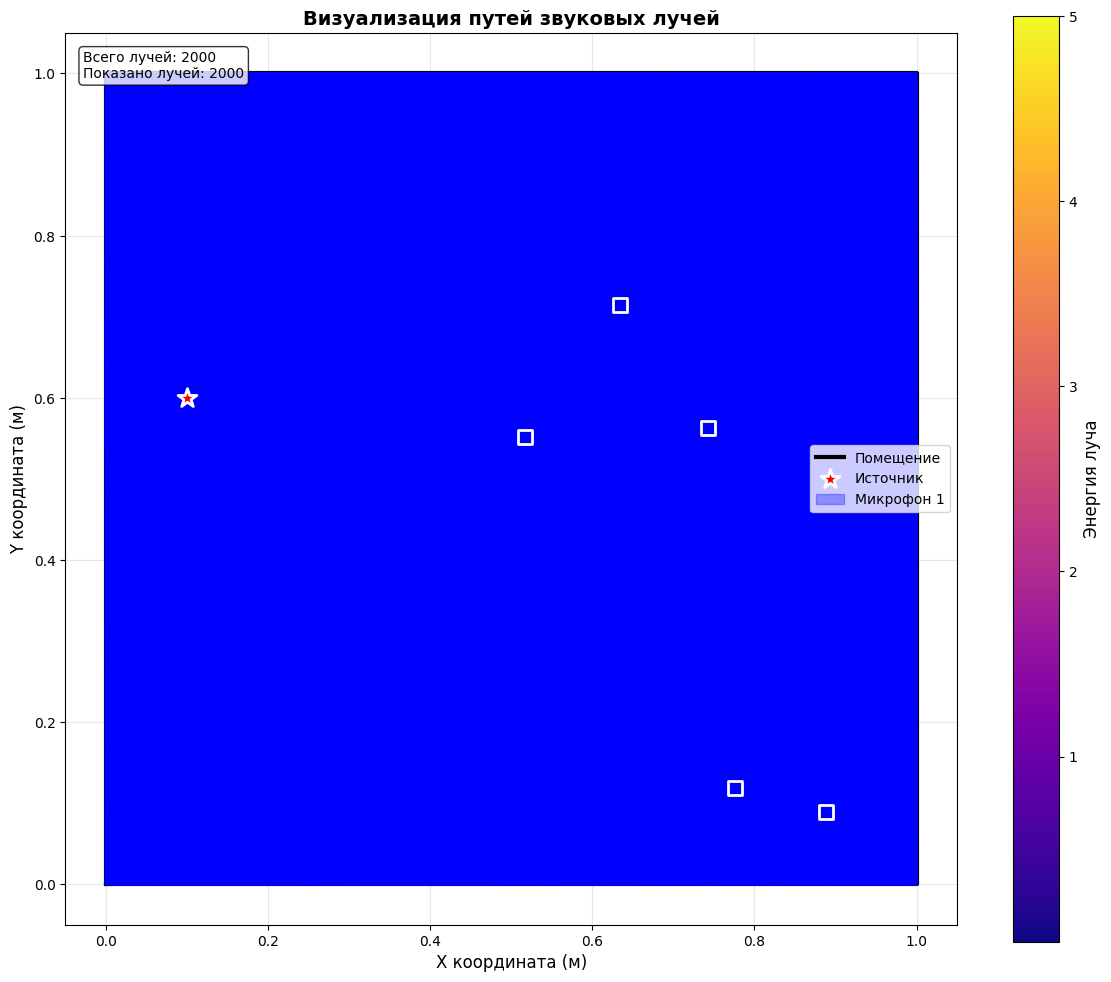

In [23]:
# ВИЗУАЛИЗАЦИЯ ПУТЕЙ ЛУЧЕЙ
print("\nСоздание визуализации путей лучей...")
fig_rays, ax_rays = plot_ray_paths(ray_paths, wallVertices, microphones, (sourceX, sourceY))
plt.show()

Energy map:

Создание энергетической карты...

=== АНАЛИЗ ПУТЕЙ ЛУЧЕЙ ===
Всего лучей: 500
Лучей с отражениями: 482
Прямых лучей: 18
Максимум сегментов в луче: 16
Среднее сегментов на луч: 9.91
Отладочная информация:
  Всего сегментов: 4957
  Всего ячеек затронуто: 398056
  Суммарная энергия в лучах: 4764.4533
  Энергия в матрице: 305930.0421
  Разница: 301165.5888
Обработка энергетической карты...


Финальная настройка: 100%|██████████| 7/7 


Визуализация энергетической карты...
Размер матрицы: (81, 101)
Суммарная энергия в матрице: 305930.04
Максимальная энергия в ячейке: 2536.37

Отображение графиков...


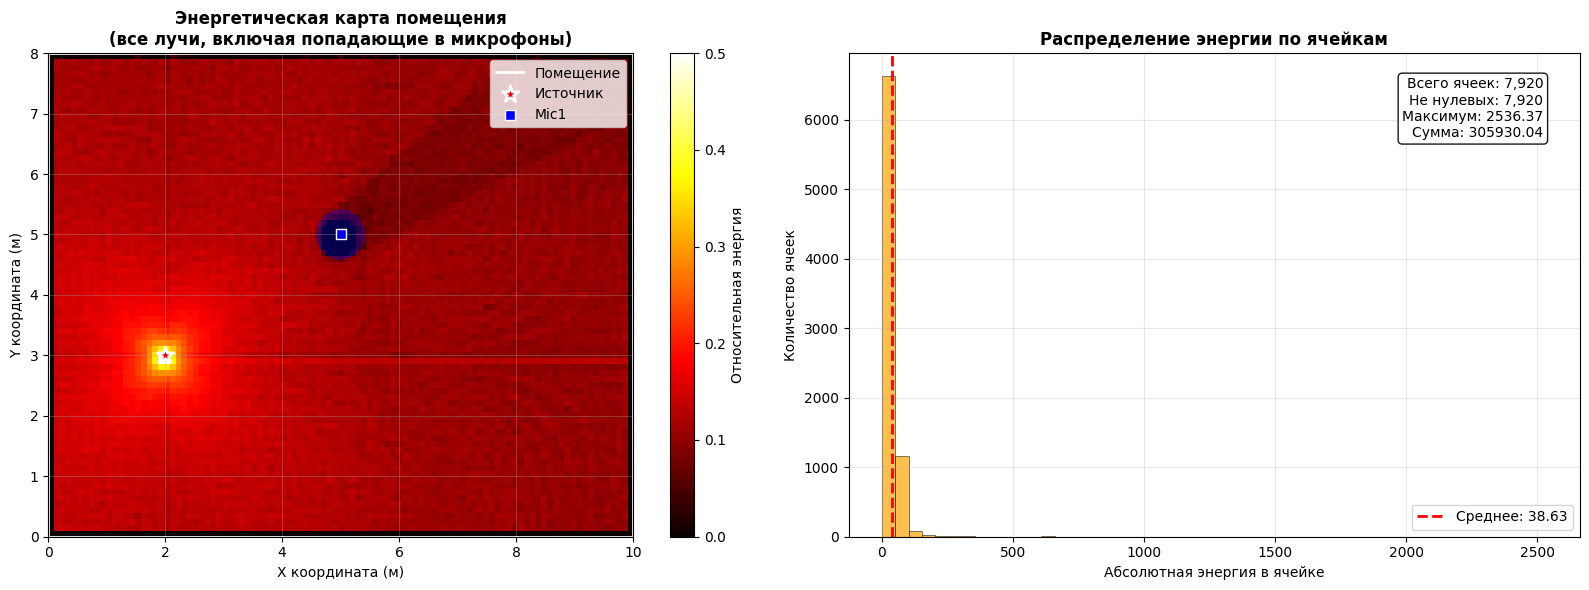


=== СТАТИСТИКА ЭНЕРГЕТИЧЕСКОЙ КАРТЫ ===
Общая энергия в помещении: 305930.04
Средняя энергия на ячейку: 38.6275
Максимальная энергия в ячейке: 2536.37
Количество ячеек с энергией: 7,826
Общее количество ячеек: 7,920


In [167]:

print("Создание энергетической карты...")

# Анализ путей лучей
analyze_ray_paths(ray_paths)

# Создаем энергетическую карту
energy_matrix, x_coords, y_coords, inside_mask = create_energy_map_numpy(
    [wallVerticesX, wallVerticesY], ray_paths, grid_size
)

# Нормализуем и улучшаем видимость
print("Обработка энергетической карты...")
with tqdm(total=7, desc="Обработка", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    if np.max(energy_matrix) > 0:
        # Нормализуем к диапазону [0, 1] для лучшей видимости
        energy_normalized = energy_matrix / np.max(energy_matrix)
        pbar.update(1)
        pbar.set_description("Нормализация")
        
        # Гамма-коррекция
        gamma = 0.5
        energy_display = energy_normalized ** gamma
        pbar.update(1)
        pbar.set_description("Гамма-коррекция")
    else:
        energy_display = energy_matrix
        pbar.update(2)
    
    # Визуализация
    print("\nВизуализация энергетической карты...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Создание основного графика
    if np.max(energy_display) > 0:
        im = ax1.imshow(energy_display, 
                        extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]], 
                        origin='lower', cmap='hot', aspect='auto',
                        vmin=0, vmax=np.max(energy_display)/2)
        plt.colorbar(im, ax=ax1, label='Относительная энергия')
    pbar.update(1)
    pbar.set_description("Основной график")
    
    # Рисуем контур помещения
    ax1.plot(np.append(wallVerticesX, wallVerticesX[0]), 
                np.append(wallVerticesY, wallVerticesY[0]), 'w-', linewidth=2, label='Помещение')
    pbar.update(1)
    pbar.set_description("Контур помещения")
    
    # Рисуем источник и микрофоны
    ax1.scatter(sourceX, sourceY, c='red', s=150, marker='*', label='Источник', 
                edgecolors='white', linewidth=2, zorder=5)
    
    for i, mic in enumerate(microphones):
        mic_x, mic_y = mic['position']
        # Показываем микрофоны синими кругами
        circle = plt.Circle((mic_x, mic_y), mic['radius'], color='blue', alpha=0.3)
        ax1.add_patch(circle)
        ax1.scatter(mic_x, mic_y, c='blue', s=50, marker='s', 
                    label=f'Mic{i+1}' if i == 0 else "", 
                    edgecolors='white', linewidth=1, zorder=5)
    
    ax1.set_xlabel('X координата (м)')
    ax1.set_ylabel('Y координата (м)')
    ax1.set_title('Энергетическая карта помещения\n(все лучи, включая попадающие в микрофоны)', 
                    fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    pbar.update(1)
    pbar.set_description("Источник и микрофоны")
    
    # График 2: Гистограмма распределения энергии
    plt.sca(ax2)
    
    energy_inside = energy_matrix[inside_mask]
    
    if len(energy_inside) > 0 and np.max(energy_inside) > 0:
        if len(energy_inside) > 0:
            plt.hist(energy_inside, bins=50, alpha=0.7, 
                    color='orange', edgecolor='black', linewidth=0.5)
            
            mean_energy = np.mean(energy_inside)
            plt.axvline(mean_energy, color='red', linestyle='--', linewidth=2, 
                        label=f'Среднее: {mean_energy:.2f}')
            
            plt.xlabel('Абсолютная энергия в ячейке')
            plt.ylabel('Количество ячеек')
            plt.title('Распределение энергии по ячейкам', fontweight='bold')
            plt.grid(True, alpha=0.3)
            plt.legend()
            
            stats_text = (f'Всего ячеек: {len(energy_inside):,}\n'
                            f'Не нулевых: {len(energy_inside):,}\n'
                            f'Максимум: {np.max(energy_inside):.2f}\n'
                            f'Сумма: {np.sum(energy_inside):.2f}')
            
            plt.text(0.95, 0.95, stats_text, transform=ax2.transAxes,
                    ha='right', va='top', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
    pbar.update(1)
    pbar.set_description("Гистограмма")
    
    plt.tight_layout()
    pbar.update(1)
    pbar.set_description("Финальная настройка")

print(f"Размер матрицы: {energy_matrix.shape}")
print(f"Суммарная энергия в матрице: {np.sum(energy_matrix):.2f}")
print(f"Максимальная энергия в ячейке: {np.max(energy_matrix):.2f}")

print("\nОтображение графиков...")
plt.show()

# СТАТИСТИКА
if len(energy_inside) > 0:
    print(f"\n=== СТАТИСТИКА ЭНЕРГЕТИЧЕСКОЙ КАРТЫ ===")
    print(f"Общая энергия в помещении: {np.sum(energy_inside):.2f}")
    print(f"Средняя энергия на ячейку: {np.mean(energy_inside):.4f}")
    print(f"Максимальная энергия в ячейке: {np.max(energy_inside):.2f}")
    print(f"Количество ячеек с энергией: {np.sum(energy_inside > 0):,}")
    print(f"Общее количество ячеек: {len(energy_inside):,}")




СОЗДАНИЕ ГРАФИКА Db/ВРЕМЯ ДЛЯ МИКРОФОНОВ

Микрофон 1:
  Всего попаданий: 349
  Общая поглощенная энергия: 235.5237
  Диапазон времени: 9.35 - 399.14 мс
  Диапазон отражений: 0 - 15

------------------------------------------------------------
СВОДНАЯ СТАТИСТИКА ПО ВСЕМ МИКРОФОНАМ
------------------------------------------------------------


C:\Users\user221123\AppData\Local\Temp\ipykernel_10744\3216912857.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')



ДЕТАЛЬНАЯ СТАТИСТИКА ПОПАДАНИЙ

Микрофон 1 (x=5.00, y=5.00):
  • Попаданий: 349
  • Суммарная энергия: 235.523682
  • Средняя энергия: 0.674853
  • Макс. энергия: 5.000000
  • Мин. энергия: 0.000153
  • Средние отражения: 6.28
  • Среднее время: 130.76 мс
  • Мин. время: 9.35 мс
  • Макс. время: 399.14 мс
  • Уникальные значения отражений: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    - 0 отражений: 18 лучей (5.2%)
    - 1 отражений: 27 лучей (7.7%)
    - 2 отражений: 32 лучей (9.2%)
    - 3 отражений: 35 лучей (10.0%)
    - 4 отражений: 25 лучей (7.2%)
    - 5 отражений: 26 лучей (7.4%)
    - 6 отражений: 30 лучей (8.6%)
    - 7 отражений: 29 лучей (8.3%)
    - 8 отражений: 23 лучей (6.6%)
    - 9 отражений: 17 лучей (4.9%)
    - 10 отражений: 23 лучей (6.6%)
    - 11 отражений: 16 лучей (4.6%)
    - 12 отражений: 14 лучей (4.0%)
    - 13 отражений: 16 лучей (4.6%)
    - 14 отражений: 6 лучей (1.7%)
    - 15 отражений: 12 лучей (3.4%)

Отображение графиков энергия/время.

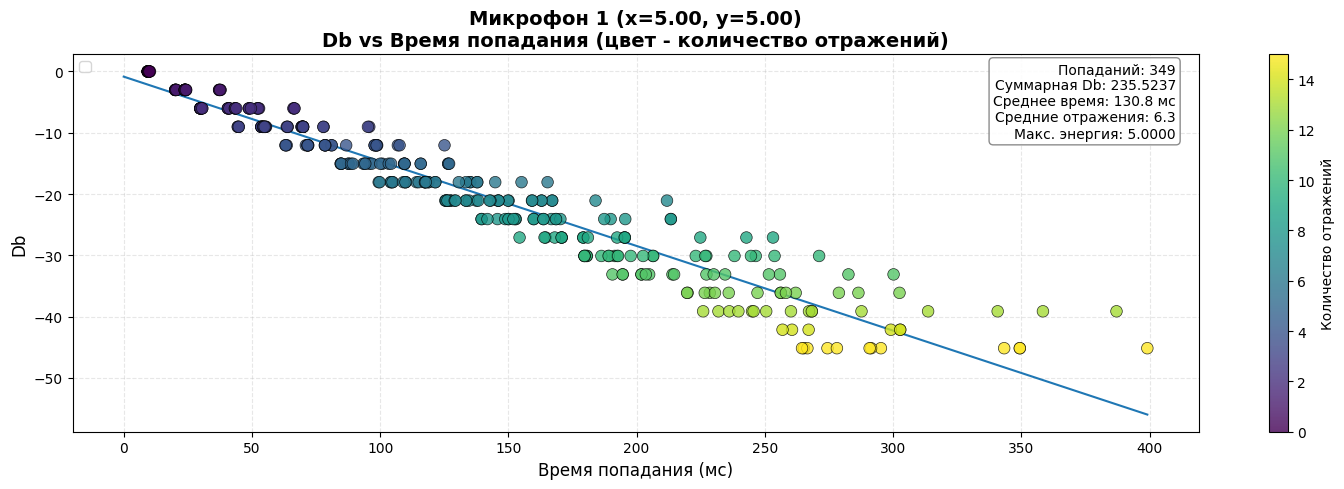

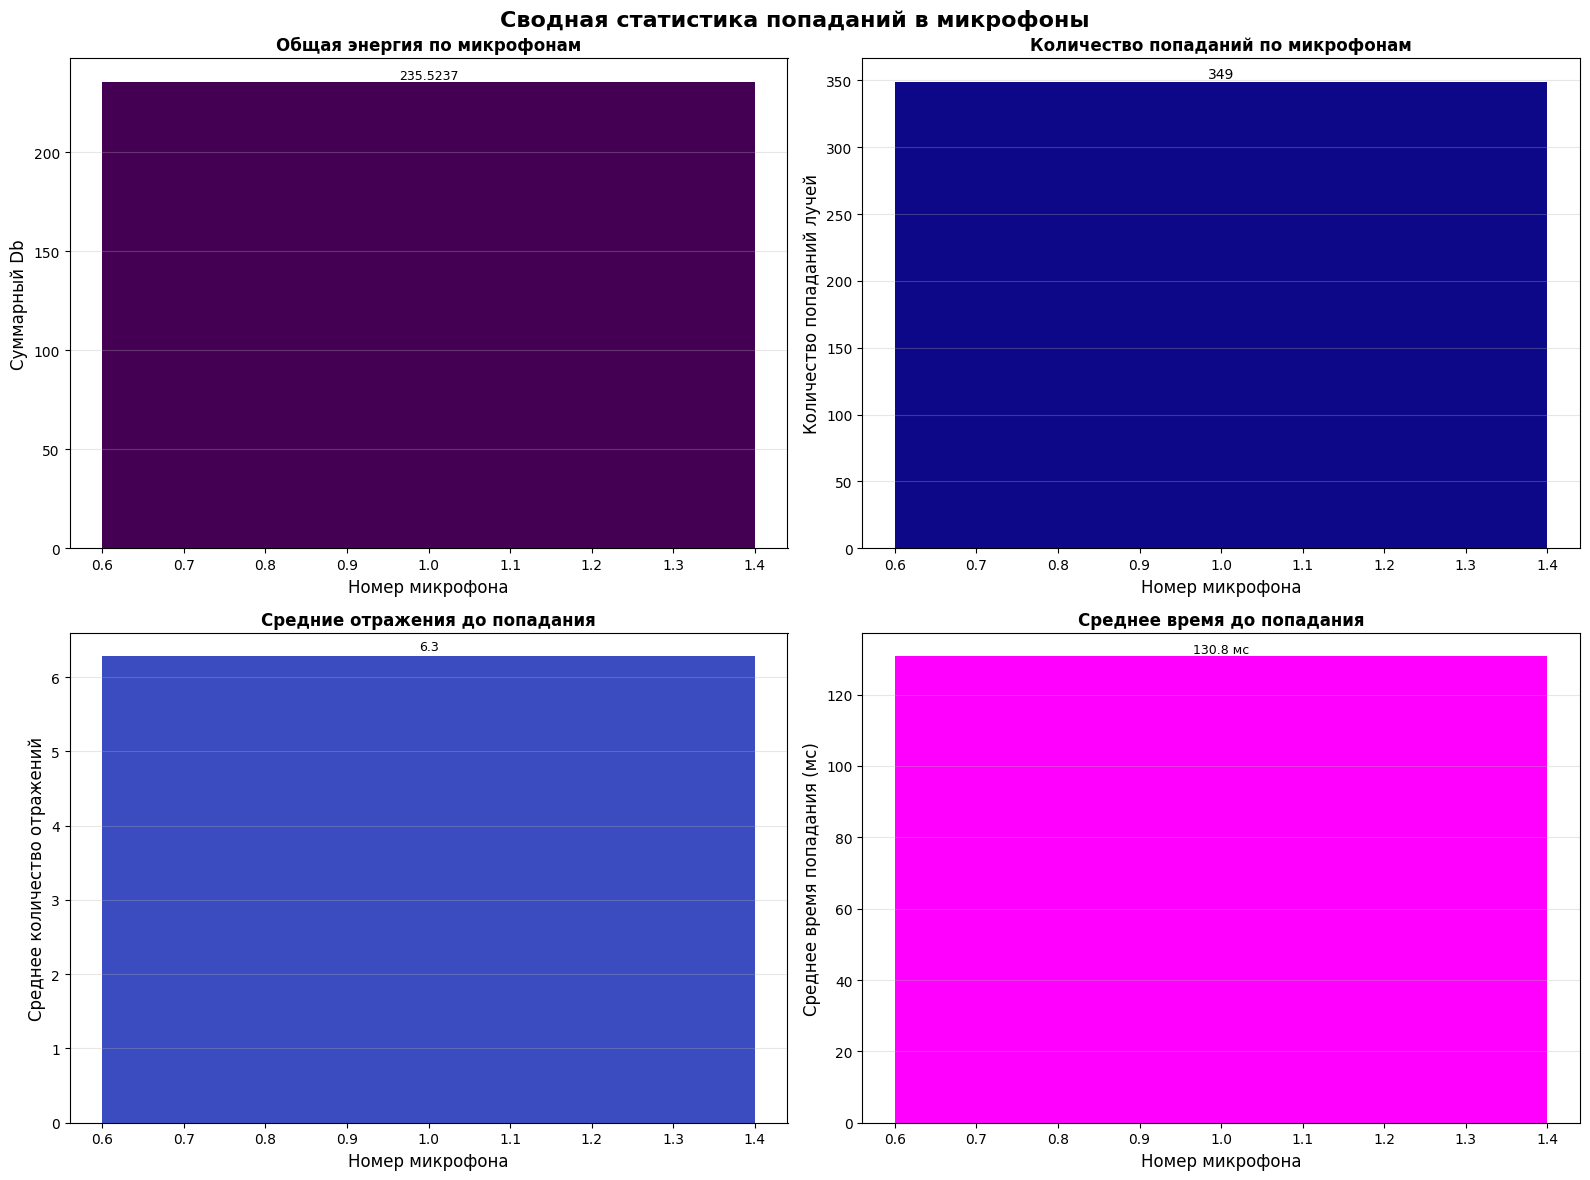

In [180]:
from re import A


if any(len(mic['energy_history']) > 0 for mic in microphones):
    print("\n" + "="*60)
    print("СОЗДАНИЕ ГРАФИКА Db/ВРЕМЯ ДЛЯ МИКРОФОНОВ")
    print("="*60)
    
    # Создаем фигуру для графика энергия/время
    fig_time_energy, axes = plt.subplots(len(microphones), 1, figsize=(15, 5*len(microphones)))
    if len(microphones) == 1:
        axes = [axes]
    
    for mic_idx, (mic, ax) in enumerate(zip(microphones, axes)):
        if len(mic['energy_history']) == 0:
            ax.text(0.5, 0.5, f'Микрофон {mic_idx+1}: Нет попаданий лучей', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title(f'Микрофон {mic_idx+1} (x={mic["position"][0]:.2f}, y={mic["position"][1]:.2f})', 
                        fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            continue
        
        # Извлекаем данные о попаданиях
        times = mic['time_history']  # Время попадания (секунды)
        energies = np.array(mic['energy_history'])  # Энергия луча при попадании
        bounce_counts = mic['bounce_history']  # Количество отражений
        
        # Преобразуем время в миллисекунды для лучшей читаемости
        times_ms = [t * 1000 for t in times]
        
        # Находим максимальное количество отражений для нормализации цвета
        max_bounces = max(bounce_counts) if bounce_counts else 1
        min_bounces = min(bounce_counts) if bounce_counts else 0
        
        # Создаем цветовую карту в зависимости от количества отражений
        norm = plt.Normalize(min_bounces, max_bounces)
        cmap = plt.cm.viridis  # Можно использовать 'plasma', 'rainbow', 'coolwarm'
        
        print(f"\nМикрофон {mic_idx+1}:")
        print(f"  Всего попаданий: {len(times)}")
        print(f"  Общая поглощенная энергия: {mic['absorbed_energy']:.4f}")
        print(f"  Диапазон времени: {min(times_ms):.2f} - {max(times_ms):.2f} мс")
        print(f"  Диапазон отражений: {min_bounces} - {max_bounces}")
        


        # Создаем scatter plot с цветом, соответствующим количеству отражений
        scatter = ax.scatter(times_ms, 10*np.log10(energies/5), 
                            c=bounce_counts, 
                            cmap=cmap, 
                            norm=norm,
                            s=70,  # Размер точек
                            alpha=0.8,
                            edgecolors='black',
                            linewidth=0.5,
                            zorder=5)
        m, b = np.polyfit(times_ms, 10*np.log10(energies/5), 1)
        ax.plot([0, max(times_ms)], [b, max(times_ms)*m+b])
        
        # Добавляем цветовую шкалу
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Количество отражений', fontsize=10)
    
        
        # Настройка осей
        ax.set_xlabel('Время попадания (мс)', fontsize=12)
        ax.set_ylabel('Db', fontsize=12)
        ax.set_title(f'Микрофон {mic_idx+1} (x={mic["position"][0]:.2f}, y={mic["position"][1]:.2f})\n'
                    f'Db vs Время попадания (цвет - количество отражений)', 
                    fontsize=14, fontweight='bold')
        
        # Добавляем сетку
        ax.grid(True, alpha=0.3, linestyle='--', zorder=0)
        
        # Добавляем статистику в углу графика
        stats_text = (f'Попаданий: {len(times)}\n'
                     f'Суммарная Db: {sum(energies):.4f}\n'
                     f'Среднее время: {np.mean(times_ms):.1f} мс\n'
                     f'Средние отражения: {np.mean(bounce_counts):.1f}\n'
                     f'Макс. энергия: {max(energies):.4f}')
        
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray'))
        
        # Добавляем легенду для линии тренда
        if len(times_ms) > 1:
            ax.legend(loc='upper left')
    
    plt.tight_layout()
    
    # ДОПОЛНИТЕЛЬНЫЙ ГРАФИК: Сводная статистика по всем микрофонам
    print("\n" + "-"*60)
    print("СВОДНАЯ СТАТИСТИКА ПО ВСЕМ МИКРОФОНАМ")
    print("-"*60)
    
    fig_summary, axes_summary = plt.subplots(2, 2, figsize=(16, 12))
    fig_summary.suptitle('Сводная статистика попаданий в микрофоны', fontsize=16, fontweight='bold')
    
    # График 1: Общая энергия по микрофонам
    ax1 = axes_summary[0, 0]
    mic_indices = range(1, len(microphones) + 1)
    total_energies = [mic['absorbed_energy'] for mic in microphones]
    
    bars = ax1.bar(mic_indices, total_energies, color=plt.cm.viridis(np.linspace(0, 1, len(microphones))))
    ax1.set_xlabel('Номер микрофона', fontsize=12)
    ax1.set_ylabel('Суммарный Db', fontsize=12)
    ax1.set_title('Общая энергия по микрофонам', fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Добавляем значения на столбцы
    for bar, energy in zip(bars, total_energies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{energy:.4f}', ha='center', va='bottom', fontsize=9)
    
    # График 2: Количество попаданий по микрофонам
    ax2 = axes_summary[0, 1]
    ray_counts = [len(mic['energy_history']) for mic in microphones]
    
    bars2 = ax2.bar(mic_indices, ray_counts, color=plt.cm.plasma(np.linspace(0, 1, len(microphones))))
    ax2.set_xlabel('Номер микрофона', fontsize=12)
    ax2.set_ylabel('Количество попаданий лучей', fontsize=12)
    ax2.set_title('Количество попаданий по микрофонам', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    for bar, count in zip(bars2, ray_counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{count}', ha='center', va='bottom', fontsize=10)
    
    # График 3: Среднее количество отражений
    ax3 = axes_summary[1, 0]
    avg_bounces = []
    for mic in microphones:
        if mic['bounce_history']:
            avg_bounces.append(np.mean(mic['bounce_history']))
        else:
            avg_bounces.append(0)
    
    bars3 = ax3.bar(mic_indices, avg_bounces, color=plt.cm.coolwarm(np.linspace(0, 1, len(microphones))))
    ax3.set_xlabel('Номер микрофона', fontsize=12)
    ax3.set_ylabel('Среднее количество отражений', fontsize=12)
    ax3.set_title('Средние отражения до попадания', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    for bar, bounces in zip(bars3, avg_bounces):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{bounces:.1f}', ha='center', va='bottom', fontsize=9)
    
    # График 4: Среднее время попадания
    ax4 = axes_summary[1, 1]
    avg_times_ms = []
    for mic in microphones:
        if mic['time_history']:
            avg_times_ms.append(np.mean(mic['time_history']) * 1000)
        else:
            avg_times_ms.append(0)
    
    bars4 = ax4.bar(mic_indices, avg_times_ms, color=plt.cm.spring(np.linspace(0, 1, len(microphones))))
    ax4.set_xlabel('Номер микрофона', fontsize=12)
    ax4.set_ylabel('Среднее время попадания (мс)', fontsize=12)
    ax4.set_title('Среднее время до попадания', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    for bar, time_val in zip(bars4, avg_times_ms):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{time_val:.1f} мс', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    
    # ВЫВОД СТАТИСТИКИ В КОНСОЛЬ
    print("\n" + "="*60)
    print("ДЕТАЛЬНАЯ СТАТИСТИКА ПОПАДАНИЙ")
    print("="*60)
    
    for mic_idx, mic in enumerate(microphones):
        if len(mic['energy_history']) > 0:
            print(f"\nМикрофон {mic_idx+1} (x={mic['position'][0]:.2f}, y={mic['position'][1]:.2f}):")
            print(f"  • Попаданий: {len(mic['energy_history'])}")
            print(f"  • Суммарная энергия: {mic['absorbed_energy']:.6f}")
            print(f"  • Средняя энергия: {np.mean(mic['energy_history']):.6f}")
            print(f"  • Макс. энергия: {max(mic['energy_history']):.6f}")
            print(f"  • Мин. энергия: {min(mic['energy_history']):.6f}")
            print(f"  • Средние отражения: {np.mean(mic['bounce_history']):.2f}")
            print(f"  • Среднее время: {np.mean(mic['time_history'])*1000:.2f} мс")
            print(f"  • Мин. время: {min(mic['time_history'])*1000:.2f} мс")
            print(f"  • Макс. время: {max(mic['time_history'])*1000:.2f} мс")
            
            # Анализ распределения по отражениям
            unique_bounces = sorted(set(mic['bounce_history']))
            print(f"  • Уникальные значения отражений: {unique_bounces}")
            for bounce_val in unique_bounces:
                count = mic['bounce_history'].count(bounce_val)
                percentage = count / len(mic['bounce_history']) * 100
                print(f"    - {bounce_val} отражений: {count} лучей ({percentage:.1f}%)")
        else:
            print(f"\nМикрофон {mic_idx+1}: Нет попаданий")
    
    # Показываем графики
    print("\nОтображение графиков энергия/время...")
    plt.show()
    
else:
    print("\nНет данных о попаданиях в микрофоны для создания графика энергия/время")